# USS Reviews Facility Labeling with Zero-Shot Classification

This notebook uses facebook/bart-large-mnli pre-trained model for zero-shot multi-label classification to automatically tag USS reviews with facility labels based on the normalized facility JSON data.


## 1. Environment Setup and Library Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/GitHub_Repos/CS605-NLP-Project

/content/drive/MyDrive/GitHub_Repos/CS605-NLP-Project


In [3]:
# Install required libraries
!pip install transformers torch pandas numpy matplotlib seaborn tqdm
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU
device_name = "GPU" if torch.cuda.is_available() else "CPU"
print(f"Using device: {device_name}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Using device: CPU


In [5]:
import os

# Ensure working from project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
    print("Adjusted working directory to project root")

## 2. Initialize Zero-Shot Classification Pipeline

In [6]:
# Initialize the zero-shot classification pipeline

def initialize_classifier():
    """
    Initialize the facebook/bart-large-mnli model for zero-shot classification
    with FP16 optimization for faster inference on compatible GPUs.
    """
    # Check if GPU is available to use float16
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32

    classifier = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=device,  # Global device variable (0 for GPU)
        torch_dtype=dtype # Use float16 for ~2x speedup on modern GPUs
    )

    print("Model loaded successfully!")
    return classifier

# Load the classifier
classifier = initialize_classifier()

Loading facebook/bart-large-mnli model with FP16 optimization...


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Model loaded successfully!


## 3. Load and Process Facility Data

In [7]:
def load_facility_labels(base_path="output/dashboard/config"):
    """
    Loads facility data and creates an updated list of 24 labels.
    - 7 main zones are top-level labels.
    - 17 general services are flattened to become individual top-level labels.
    """
    main_facilities_filename = 'FullList_normalized_v1.json'
    other_facilities_filename = 'others_normalized_v1.json'

    main_facilities_path = os.path.join(base_path, main_facilities_filename)
    other_facilities_path = os.path.join(base_path, other_facilities_filename)

    # Load main facility categories
    with open(main_facilities_path, 'r') as f:
        main_facilities = json.load(f)

    # Load other facilities (general services)
    with open(other_facilities_path, 'r') as f:
        other_facilities = json.load(f) # This is a list of 17 service keywords

    # Create the new list of 24 unique facility labels
    zone_names = list(main_facilities.keys())
    # The facilities list combines the 7 zones with the 17 general services
    unique_facilities = zone_names + other_facilities

    print(f"Total number of unique labels created: {len(unique_facilities)}")

    # Create mapping: sub-item keyword → main label name
    facility_categories = {}

    # Map all sub-items to their parent zone for the 7 main zones
    for zone, categories in main_facilities.items():
        for category, items in categories.items():
            for item in items:
                # Map sub-item keyword to its zone name
                facility_categories[item] = zone

    # Map each general service keyword to itself as a label
    for facility in other_facilities:
        facility_categories[facility] = facility

    # Create label mapping dictionaries
    label2id = {label: idx for idx, label in enumerate(unique_facilities)}
    id2label = {idx: label for label, idx in label2id.items()}

    # Group keywords by the final facility label for printing
    facility_to_keywords = {}
    for keyword, facility in facility_categories.items():
        if facility not in facility_to_keywords:
            facility_to_keywords[facility] = []
        # For the 7 main zones, this will group multiple keywords.
        # For the 17 services, this will create a group with one keyword.
        facility_to_keywords[facility].append(keyword)

    # Print each facility and its keywords for verification
    for i, facility in enumerate(unique_facilities, 1):
        keywords = facility_to_keywords.get(facility, [])
        print(f"\n{i}. {facility.upper()} ({len(keywords)} keywords):")

        sorted_keywords = sorted(keywords)
        for j, keyword in enumerate(sorted_keywords, 1):
            print(f"   {j:2d}. {keyword}")

    return unique_facilities, label2id, id2label, main_facilities, other_facilities, facility_categories

# Load facility data
facilities, label2id, id2label, main_facilities, other_facilities, facility_categories = load_facility_labels()

Total number of unique labels created: 24

1. MINION LAND (15 keywords):
    1. ba na na cabana
    2. buggie boogie
    3. despicable me family portrait
    4. despicable me minion mayhem
    5. fun store
    6. gru lucy
    7. ice cream stand
    8. minion dance party
    9. minute of minion mayhem
   10. pop a nana
   11. pop store
   12. silly swirly
   13. space killer
   14. super hungry food stand
   15. sweet surrender

2. HOLLYWOOD (12 keywords):
    1. candylicious
    2. hello kitty studio store
    3. lake hollywood spectacular
    4. mel s drive in
    5. mel s mixtape
    6. minion mart
    7. pantages hollywood theater trolls hug time jubilee
    8. po and master tigress
    9. pops popcorn delight
   10. starbucks
   11. the dark room
   12. universal studios store

3. NEW YORK (8 keywords):
    1. big bird s emporium
    2. kt s grill
    3. lights camera action
    4. loui s ny pizza parlor
    5. me want cookie
    6. rhythm truck
    7. sesame street
    8. sesame s

## 4. Load and Preprocess Review Data

In [6]:
# Load review data
def load_review_data(base_path="data/processed/"):
    """
    Load USS review data from Parquet file
    """
    df = pd.read_parquet(os.path.join(base_path, 'USS_Reviews_Silver_cleaned_l2.parquet'))

    # Basic data exploration
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nSample review:")
    print(df['review'].iloc[0])

    return df

# Text preprocessing function
def preprocess_text(text):
    """
    Clean and preprocess review text for better classification
    """
    if pd.isna(text):
        return ""

    # Convert to string
    text = str(text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Keep original case for better entity recognition
    return text

# Load and preprocess the review dataset
reviews_df = load_review_data()

# Apply text preprocessing
reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_text)

# Remove empty reviews
reviews_df = reviews_df[reviews_df['processed_review'] != ""].reset_index(drop=True)

print(f"\nDataset shape after preprocessing: {reviews_df.shape}")

Dataset shape: (24021, 7)

Columns: ['integrated_review', 'stars', 'name', 'review', 'publishedAtDate', 'data_split', 'review_index']

Sample review:
Nice lot if activities need entire day to cover all

Dataset shape after preprocessing: (24021, 8)


## 5. Zero-Shot Classification Functions

In [48]:
def classify_reviews(reviews, facilities, classifier, batch_size=32):
    """
    Runs batch classification and returns the raw scores for all labels for each review.
    This is the most flexible approach, as thresholding can be done later.
    """
    results = []
    print(f"Starting efficient inference for {len(reviews)} reviews...")
    print(f"Using Batch Size: {batch_size}. ")

    # Process reviews in batches
    for i in tqdm(range(0, len(reviews), batch_size), desc="Classifying Batches"):
        batch_reviews = reviews[i:i+batch_size]
        try:
            # Get the raw output from the classifier for the current batch
            batch_results = classifier(
                batch_reviews,
                facilities,
                multi_label=True,
                batch_size=len(batch_reviews)
            )

            # The classifier returns a list of dicts, one for each review in the batch
            results.extend(batch_results)

        except Exception as e:
            print(f"An error occurred in batch starting at index {i}: {e}")
            # For robustness, add empty results for the failed batch
            for _ in batch_reviews:
                results.append({'labels': facilities, 'scores': [0.0] * len(facilities)})

    return results

## 6. Apply Zero-Shot Classification to All Reviews

In [98]:
BATCH_SIZE = 32

raw_classification_results = classify_reviews(
    reviews_df['processed_review'].tolist(),
    facilities,
    classifier,
    batch_size=BATCH_SIZE
)

Starting efficient inference for 24021 reviews...
Using Batch Size: 32. 


Classifying Batches: 100%|██████████| 751/751 [20:09<00:00,  1.61s/it]


In [99]:
import pickle
results_savename = 'data/gold/facility_labeling/raw_facility_labeling_outputs.pkl'

with open(results_savename, 'wb') as f:
    pickle.dump(raw_classification_results, f)
print(f"Results saved successfully. Located in {results_savename}")

Results saved successfully. Located in data/gold/facility_labeling/raw_facility_labeling_outputs.pkl


In [9]:
import pickle
results_savename = 'data/gold/facility_labeling/raw_facility_labeling_outputs.pkl'

with open(results_savename, 'rb') as f:
        raw_classification_results = pickle.load(f)

## 7. Process and Format Results

In [29]:
def process_results_multi_label(results, facilities, confidence_threshold=0.85):
    """
    Processes raw scores, creating a list of all facility labels that
    exceed a given confidence threshold for each review.
    """
    all_predicted_labels = []

    for res in results:
        scores = res.get('scores', [])
        labels = res.get('labels', [])
        predicted_labels_for_this_review = []

        if scores and labels:
            for label, score in zip(labels, scores):
                if score >= confidence_threshold:
                    predicted_labels_for_this_review.append(label)

        if not predicted_labels_for_this_review:
            predicted_labels_for_this_review = ['Unknown']

        all_predicted_labels.append(predicted_labels_for_this_review)

    return pd.DataFrame({'predicted_facilities_list': all_predicted_labels})


# --- Step 1: Process the raw results with the multi-label logic ---
CONFIDENCE_THRESHOLD = 0.95
print(f"\nProcessing results for multi-label classification with threshold: {CONFIDENCE_THRESHOLD}")
multi_label_df = process_results_multi_label(
    raw_classification_results,
    facilities,
    confidence_threshold=CONFIDENCE_THRESHOLD
)

# --- Step 2: Create and save the new, clean CSV file as requested ---

print("\nCreating new clean CSV file with multi-label predictions...")

# Define the specific columns you want to keep from the original data
columns_to_keep = [
    'integrated_review',
    'stars',
    'name',
    'review',
    'publishedAtDate',
    'review_index'
]

# Create a new, clean dataframe with ONLY the desired columns
df_for_export = reviews_df[columns_to_keep].copy()

# Add your new multi-label predictions column
df_for_export['predicted_facilities'] = multi_label_df['predicted_facilities_list'].apply(
    lambda labels_list: ', '.join(labels_list)
)

# --- Define output path and save the file ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
output_filename = "USS_Reviews_MultiLabel_Predictions.csv"
output_path = os.path.join(output_dir, output_filename)

# Save the selected columns to the new CSV file
df_for_export.to_csv(output_path, index=False)

print(f"✓ Successfully saved new predictions to: {output_path}")
print("\nSample of the final saved dataframe:")
print(df_for_export.head())


Processing results for multi-label classification with threshold: 0.95

Creating new clean CSV file with multi-label predictions...
✓ Successfully saved new predictions to: data/processed/USS_Reviews_MultiLabel_Predictions.csv

Sample of the final saved dataframe:
                                   integrated_review  stars    name  \
0  Nice lot if activities need entire day to cove...      4  user_0   
1  Universal Studios Singapore offers an unforget...      5  user_1   
2  Mummy ride was great but cost way too much for...      2  user_2   
3  We went there to enjoy the Minions. It's hot d...      4  user_3   
4  Universal Studio's famous Playland Singapore. ...      5  user_4   

                                              review publishedAtDate  \
0  Nice lot if activities need entire day to cove...      2025-05-23   
1  Universal Studios Singapore offers an unforget...      2025-05-23   
2  Mummy ride was great but cost way too much for...      2025-05-23   
3  We went there to

## 7. Results Analysis and Visualization

Top 20 predicted facilities (Multi-Label Count):
              facility  predicted_count prediction_percentage
0              Unknown            22060                91.84%
1              express              912                 3.80%
2              lockers              241                 1.00%
3          sci-fi city              139                 0.58%
4       retail outlets              120                 0.50%
5          restaurants              100                 0.42%
6         far far away              100                 0.42%
7       guest services               74                 0.31%
8            restrooms               73                 0.30%
9                 atms               62                 0.26%
10         minion land               61                 0.25%
11           hollywood               61                 0.25%
12       ancient egypt               61                 0.25%
13      the lost world               55                 0.23%
14          child swa

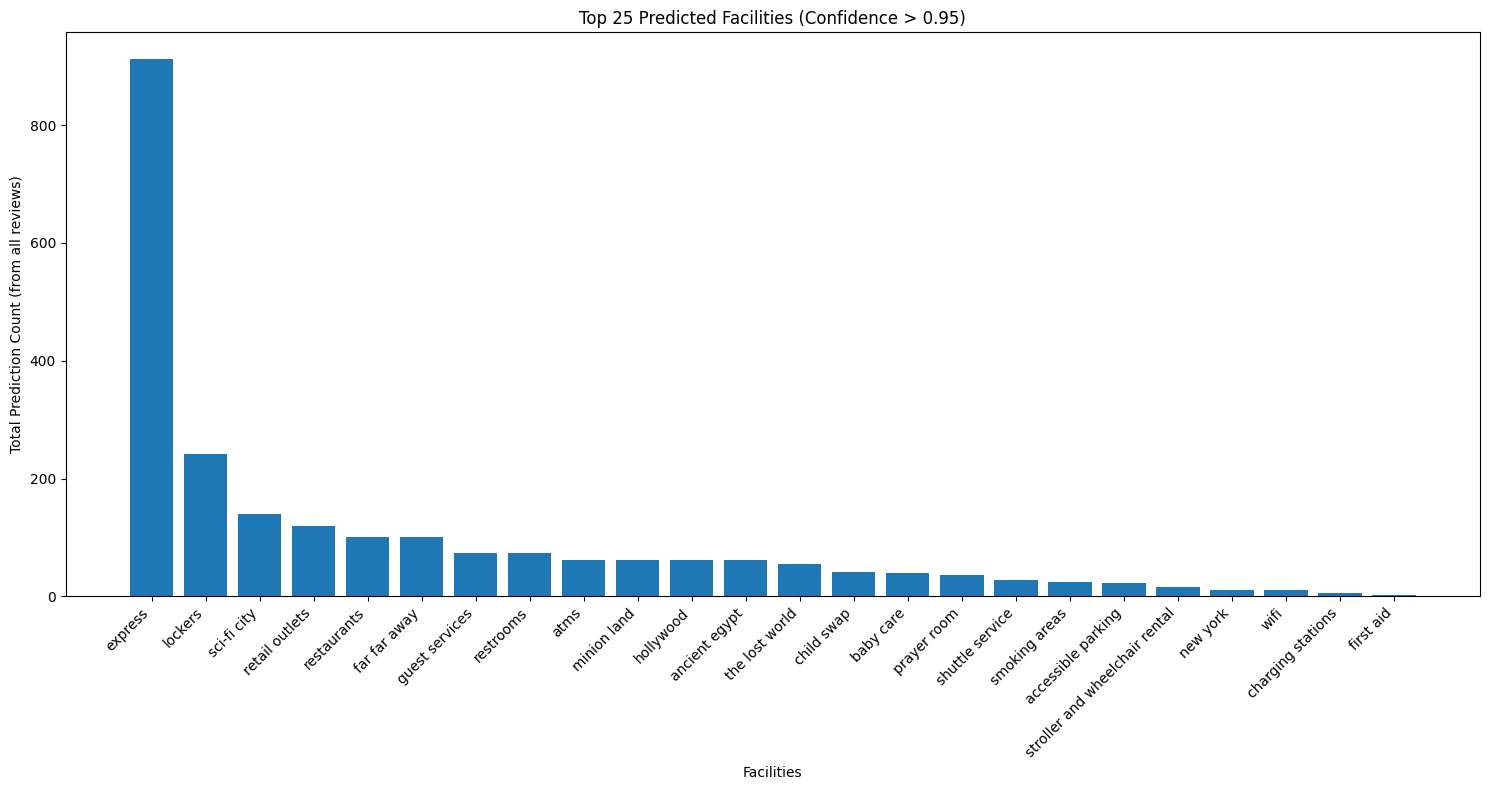

In [25]:
def analyze_predictions(df_exploded): # Note: the input is the exploded dataframe
    """
    Analyze and visualize the multi-label prediction results.
    This function assumes the input dataframe has been 'exploded'.
    """
    # Count predictions by counting occurrences of each facility in the exploded column
    facility_counts = df_exploded['predicted_facilities'].value_counts()

    # Create DataFrame for analysis
    prediction_stats = pd.DataFrame({
        'facility': facility_counts.index,
        'predicted_count': facility_counts.values
    })

    # Calculate percentage based on the original number of reviews, not the exploded length
    total_reviews = len(reviews_df) # Use the original dataframe length for percentage
    prediction_stats['prediction_percentage'] = (
        prediction_stats['predicted_count'] / total_reviews * 100
    )

    # For display, format the percentage
    display_stats = prediction_stats.copy()
    display_stats['prediction_percentage'] = display_stats['prediction_percentage'].map('{:.2f}%'.format)

    print("Top 20 predicted facilities (Multi-Label Count):")
    print(display_stats.head(20))

    # Plot predictions (vertical bar chart)
    plt.figure(figsize=(15, 8))

    # Exclude 'Unknown' for a clearer plot of actual facilities
    plot_data = prediction_stats[prediction_stats['facility'] != 'Unknown'].head(25)

    plt.bar(plot_data['facility'], plot_data['predicted_count'])

    plt.xlabel('Facilities')
    plt.ylabel('Total Prediction Count (from all reviews)')
    plt.title(f'Top 25 Predicted Facilities (Confidence > {CONFIDENCE_THRESHOLD})')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return prediction_stats

# IMPORTANT: Run the analysis on the 'df_for_analysis' dataframe
prediction_analysis = analyze_predictions(df_for_analysis)

## 8. Save Results and Create Output Files

In [26]:
# Save the enhanced dataset with predictions
output_filename = 'data/processed/USS_Reviews_With_Facility_Labels_ZeroShot.csv'
reviews_df.to_csv(output_filename, index=False)

print(f"Enhanced dataset saved as: {output_filename}")
print(f"Dataset shape: {reviews_df.shape}")
print(f"Number of facility prediction columns: {len(facilities)}")
print(f"Number of facility confidence columns: {len(facilities)}")

# Save prediction statistics
prediction_analysis.to_csv('output/results/csv/Facility_Prediction_Statistics_ZeroShot.csv', index=False)

# Save facility mapping for future reference
facility_mapping = {
    'facilities': facilities,
    'label2id': label2id,
    'id2label': id2label,
    'facility_categories': facility_categories,
    'model_info': {
        'model_name': 'facebook/bart-large-mnli',
        'task': 'zero-shot-classification',
        'confidence_threshold': CONFIDENCE_THRESHOLD,
        'multi_label': True
    }
}

with open('output/results/json/facility_mapping_zeroshot.json', 'w') as f:
    json.dump(facility_mapping, f, indent=2)

Enhanced dataset saved as: data/processed/USS_Reviews_With_Facility_Labels_ZeroShot.csv
Dataset shape: (24021, 11)
Number of facility prediction columns: 24
Number of facility confidence columns: 24
